In [57]:
pip install -U sagemaker

Note: you may need to restart the kernel to use updated packages.


In [58]:
import sagemaker
import jinja2
from sagemaker import image_uris
import boto3
import io

role = sagemaker.get_execution_role()  # execution role for the endpoint
sess = sagemaker.session.Session()  # sagemaker session for interacting with different AWS APIs
bucket = sess.default_bucket()  # bucket to house artifacts

sm_client = boto3.client("sagemaker")
prefix = "storyboard/djl/models"

### > Prepare inference script and container image

In [59]:
inference_image_uri = image_uris.retrieve(
    framework="djl-deepspeed", region=sess.boto_session.region_name, version="0.26.0"
)
inference_image_uri

'763104351884.dkr.ecr.us-east-1.amazonaws.com/djl-inference:0.26.0-deepspeed0.12.6-cu121'

### > download models

In [60]:
from pathlib import Path
import tarfile, os
import shutil
from huggingface_hub import snapshot_download

model_id = [
    "blink7630/storyboard-sketch",
    "latent-consistency/lcm-lora-sdxl",
]

In [61]:
for ids in model_id:
    # Create local dir to download models into
    model_tar_dir = Path(ids.split("/")[-1])
    if model_tar_dir.exists():
        shutil.rmtree(str(model_tar_dir))
    model_tar_dir.mkdir(exist_ok=True)

    # Download model from Hugging Face into model_dir and adding
    # to the tarfile then deleting from local directory
    snapshot_download(
        ids, 
        local_dir=str(model_tar_dir),
        local_dir_use_symlinks=False,
        allow_patterns=["*.safetensors", "*.json"]
    )
    shutil.move(str(model_tar_dir), "sdxl")

    print(f"{model_tar_dir} archive complete")

Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

storyboard-sketch archive complete


Fetching 4 files:   0%|          | 0/4 [00:00<?, ?it/s]

config.json:   0%|          | 0.00/631 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

sdxl.vae.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

sdxl_vae.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

sdxl-vae-fp16-fix archive complete


Fetching 1 files:   0%|          | 0/1 [00:00<?, ?it/s]

lcm-lora-sdxl archive complete


### > prepare the model tarball file and upload to S3

In [137]:
!rm -rf `find -type d -name .ipynb_checkpoints`

In [138]:
!find . | grep -E "(/__pycache__$|\.pyc$|\.pyo$)" | xargs rm -rf

In [113]:
!tar czvf model.tar.gz sdxl

sdxl/
sdxl/model.py
sdxl/requirements.txt
sdxl/serving.properties
sdxl/storyboard-sketch/
sdxl/storyboard-sketch/Storyboard_sketch.safetensors
sdxl/sdxl-vae-fp16-fix/
sdxl/sdxl-vae-fp16-fix/config.json
sdxl/sdxl-vae-fp16-fix/diffusion_pytorch_model.safetensors
sdxl/sdxl-vae-fp16-fix/sdxl.vae.safetensors
sdxl/sdxl-vae-fp16-fix/sdxl_vae.safetensors
sdxl/lcm-lora-sdxl/
sdxl/lcm-lora-sdxl/pytorch_lora_weights.safetensors


In [114]:
s3_code_artifact = sess.upload_data("model.tar.gz", bucket, prefix)
print(f"S3 Code or Model tar ball uploaded to --- > {s3_code_artifact}")

S3 Code or Model tar ball uploaded to --- > s3://sagemaker-us-east-1-376678947624/storyboard/djl/models/model.tar.gz


### > Deploy model

In [128]:
from sagemaker.model import Model
from sagemaker.utils import name_from_base

model_name = name_from_base("SDXL-Storyboard")

model = Model(
    image_uri=inference_image_uri,
    model_data=s3_code_artifact,
    role=role,
    name=model_name,
)

In [129]:
%%time
endpoint_name = "endpoint-" + model_name
model.deploy(
    initial_instance_count=1,
    instance_type="ml.g5.2xlarge",
    endpoint_name=endpoint_name
)

--------------!CPU times: user 125 ms, sys: 0 ns, total: 125 ms
Wall time: 7min 33s


In [130]:
%store endpoint_name

Stored 'endpoint_name' (str)


### >  Testing

In [131]:
from PIL import Image
import base64
import json

smr = boto3.client("sagemaker-runtime")

In [132]:
prompt = "storyboard sketch extreme closeup dutch angle of Lara Croft running through the jungle with a machete, angry, drama shot, looking at the camera, (foreshortening:1.2), loose debris falling, motion blur "
nprompt = "extra digit, fewer digits, cropped, worst quality, low quality, glitch, deformed, mutated, ugly, disfigured"
seed = 0

In [133]:
def _decode(image):
    image = base64.b64decode(image)
    image = Image.open(io.BytesIO(image))
    return image

In [134]:
%time
response_model = smr.invoke_endpoint(
        EndpointName=endpoint_name,
        Body=json.dumps(
            {
                "prompt": prompt,
                "nprompt": nprompt,
                "seed": seed,
                "steps": 4,
                "h": 1024,
                "w": 1024,
            }
        ),
        ContentType="application/json",
    )

CPU times: user 2 µs, sys: 0 ns, total: 2 µs
Wall time: 5.96 µs


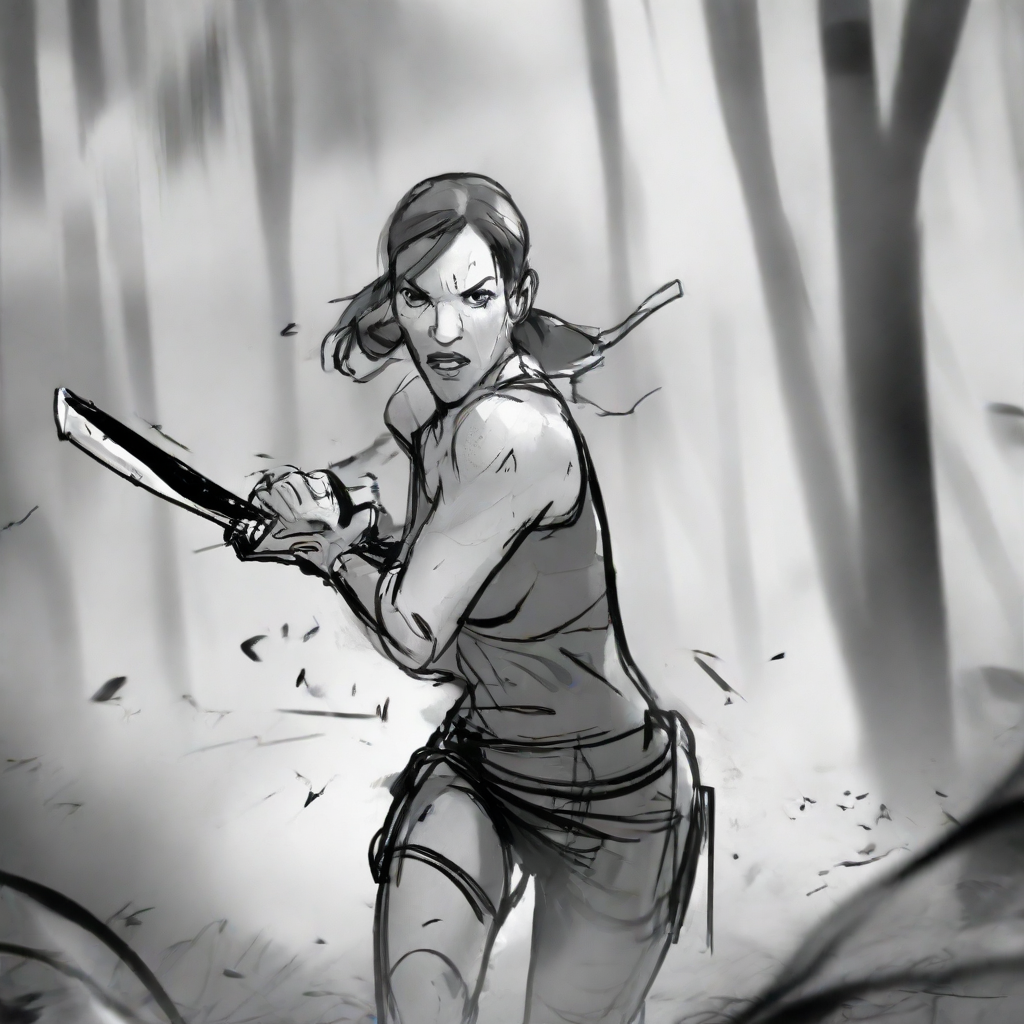

In [135]:
output = json.loads(response_model["Body"].read().decode("utf8"))["outputs"]
image = _decode(output)
image

In [136]:
endpoint_name

'endpoint-SDXL-Storyboard-2024-03-16-23-30-53-696'